# What is Time Series

Time series is a **sequence** of data in successive order of time. The value of data when combined with time ofen become more useful. We can gain more information by doing timeseries analysis, wich often resulting in forecasting. Let's take a look in a most common time series data, stock data.

A few days ago (January 25th, 2020 to be exact), I read an article saying that Tesla has overcome Volkswagen becoming the second most valuable auto company before General Motor, and Volkswagen praised Tesla and start its path to renewable energy (electric car). This is a great news since i'm a fan of Tesla. So now, let's try to take their stock price from yahoo.  

source: [bbc](https://www.bbc.com/news/business-51214824), [wall street journal](https://www.wsj.com/articles/tesla-tops-volkswagen-to-become-second-most-valuable-auto-maker-11579709320)

In [1]:
from pandas_datareader import data
import pandas as pd

In [24]:
symbol = ['VOW3.DE', 'TSLA']
# symbol = ['AAPL', 'TL0.DE']
source = 'yahoo'
start_date = '2012-01-01'
end_date = '2020-01-20'
stock = data.DataReader(symbol, source, start_date, end_date)

In [293]:
vw = stock.xs('VOW3.DE', level='Symbols', axis=1)
tesla = stock.xs('TSLA', level='Symbols', axis=1)

In [294]:
apple = apple.resample('D').mean().fillna(method='ffill').fillna(method='bfill')

In [295]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

from pylab import rcParams

In [296]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.plot(x, y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

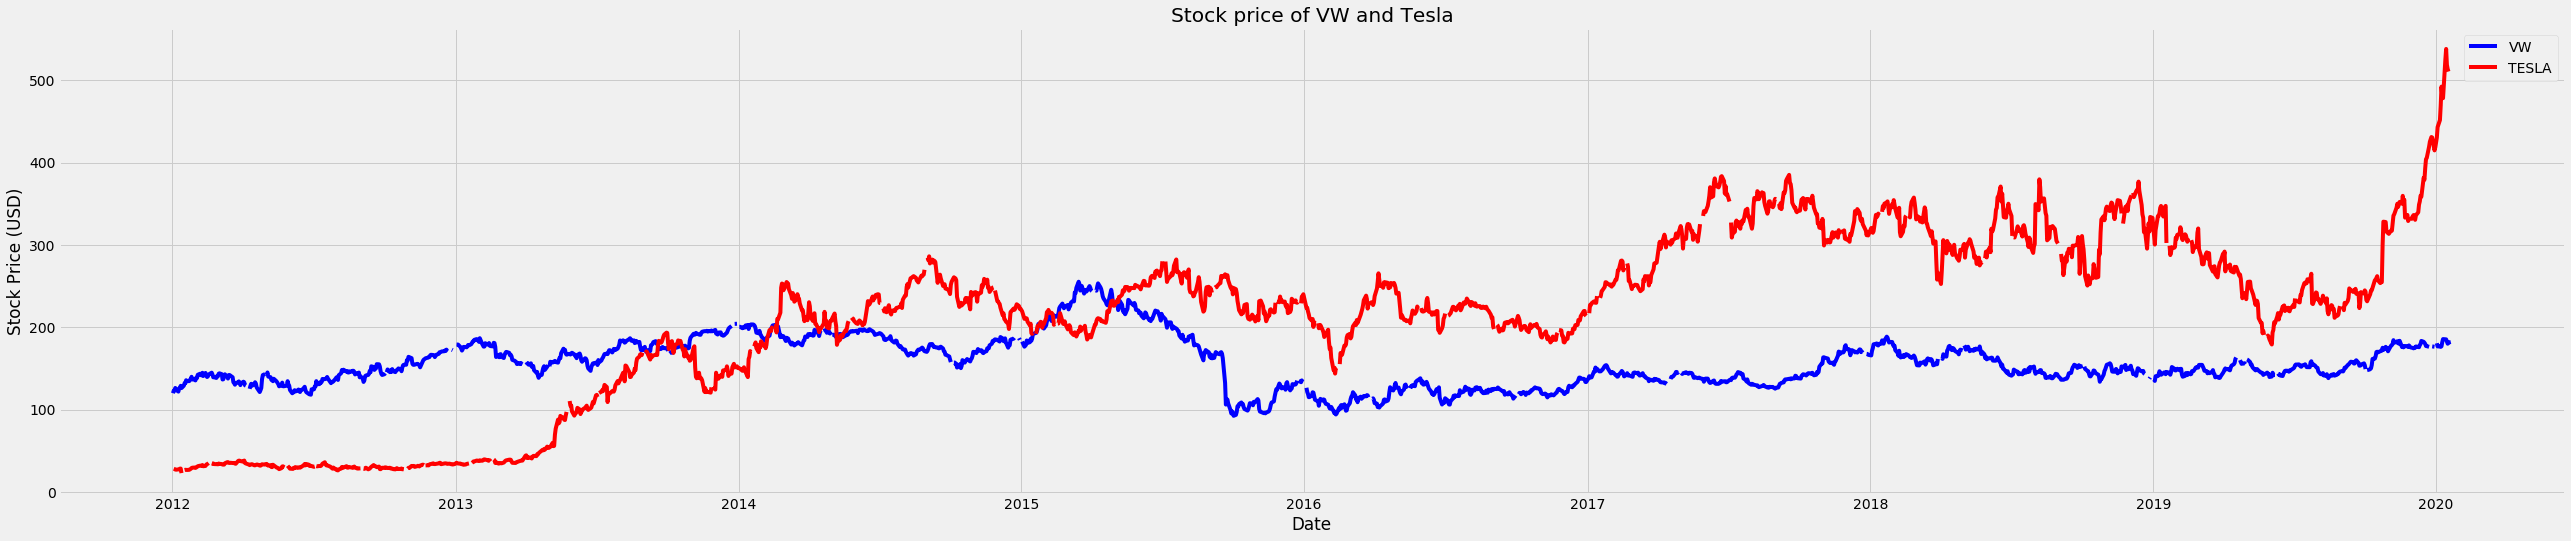

In [297]:
# plot_df(apple, apple.index, apple['Close'])
rcParams['figure.figsize'] = 40, 8
plt.plot(vw.index, vw['Close'], 'b-', label = 'VW')
plt.plot(tesla.index, tesla['Close'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Stock Price (USD)')
plt.title('Stock price of VW and Tesla')
plt.legend();

If you see the intersect, actually Tesla has overcome Volkswagen in the end of 2015, so why is it reported now ? well.. the graph above is a stock price chart. **It doesn't represent** the value of a company. The real value of a company (Market Cap) = Stock Price * Shares. It is true that Tesla's stock price has overcome VW years ago. But Tesla's shares is not many as VW's then, making it less valueable. 

# Missing Values in Time-Series Object

Before we continue, we need to cleanup the data first. As you can see, there are holes in some dates. This could be happened due to market error, or something we haven't inspect yet. We need to fix it otherwise the forecasting model can't work properly. 

In [298]:
print(f"""Tesla Missing Values: {tesla.isna().any(axis=1).sum()}\n{tesla[tesla.isna().any(axis=1)].index} \n
Volkswagen Missing Values: {vw.isna().any(axis=1).sum()}\n{vw[vw.isna().any(axis=1)].index}""")


Tesla Missing Values: 54
DatetimeIndex(['2012-01-02', '2012-01-16', '2012-02-20', '2012-05-28',
               '2012-07-04', '2012-09-03', '2012-10-29', '2012-10-30',
               '2012-11-22', '2013-01-21', '2013-02-18', '2013-05-27',
               '2013-07-04', '2013-09-02', '2013-11-28', '2014-01-20',
               '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01',
               '2014-11-27', '2015-01-19', '2015-02-16', '2015-07-03',
               '2015-09-07', '2015-11-26', '2015-12-25', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2017-01-02', '2017-01-16', '2017-02-20',
               '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-23',
               '2018-01-15', '2018-02-19', '2018-05-28', '2018-07-04',
               '2018-09-03', '2018-11-22', '2018-12-05', '2019-01-21',
               '2019-02-18', '2019-05-27', '2019-07-04', '2019-09-02',
               '2019-11-28', '2020-01-20'],
        

There are many ways to fill these `nan`s. If you have a good forecasting model, you may predict each missing values. But it's not what we're gonna do since we haven't modelled it yet. SO let's start with the most simple method, doing a `ffill` or `bfill` to just copy the previous/afterward data value. 

In [299]:
def fill_missing(df):
    return df.fillna(method='ffill').fillna(method='bfill')

In [300]:
tesla, vw = fill_missing(tesla), fill_missing(vw)

In [301]:
print(f"""Tesla Missing Values: {tesla.isna().any(axis=1).sum()}
Volkswagen Missing Values: {vw.isna().any(axis=1).sum()}""")

Tesla Missing Values: 0
Volkswagen Missing Values: 0


Now we're good to go. For the rest of this notebook, we will only use Tesla data to reduce the redundance. 

# Time series Components

There are three components of time-series data: 
- Trend: the movement of the data on a larger scale (moving average)
- Seasonality: repeated seasonal fluctuations
- Residual: any fluctuations not captured from trend or seasonality (should be random)

A time series can be modeled as **additive** or **multiplicative** time series depending on its nature of trend and seasonality. \
**Aditive Time Series** \
observed = Trend + Seasonal + Residual \
**Multiplicative Time Series** \
observed = Trend $\times$ Seasonal $\times$ Residual

*Source: Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on January 22, 2020.*

So, how we diffrentiate additive and multiplicative time series, please take a look an example image below ([source](https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/))
![](res/add_vs_multi.png)

Based on data values, if the magnitude of seasonality changes overtime (see image on the right), then the data is multiplicative. Our data however doesn't show clear evidence of growing/shrinking magnitude of seasonality, so we assume it's an additive time series. Please take a look at it once again. 

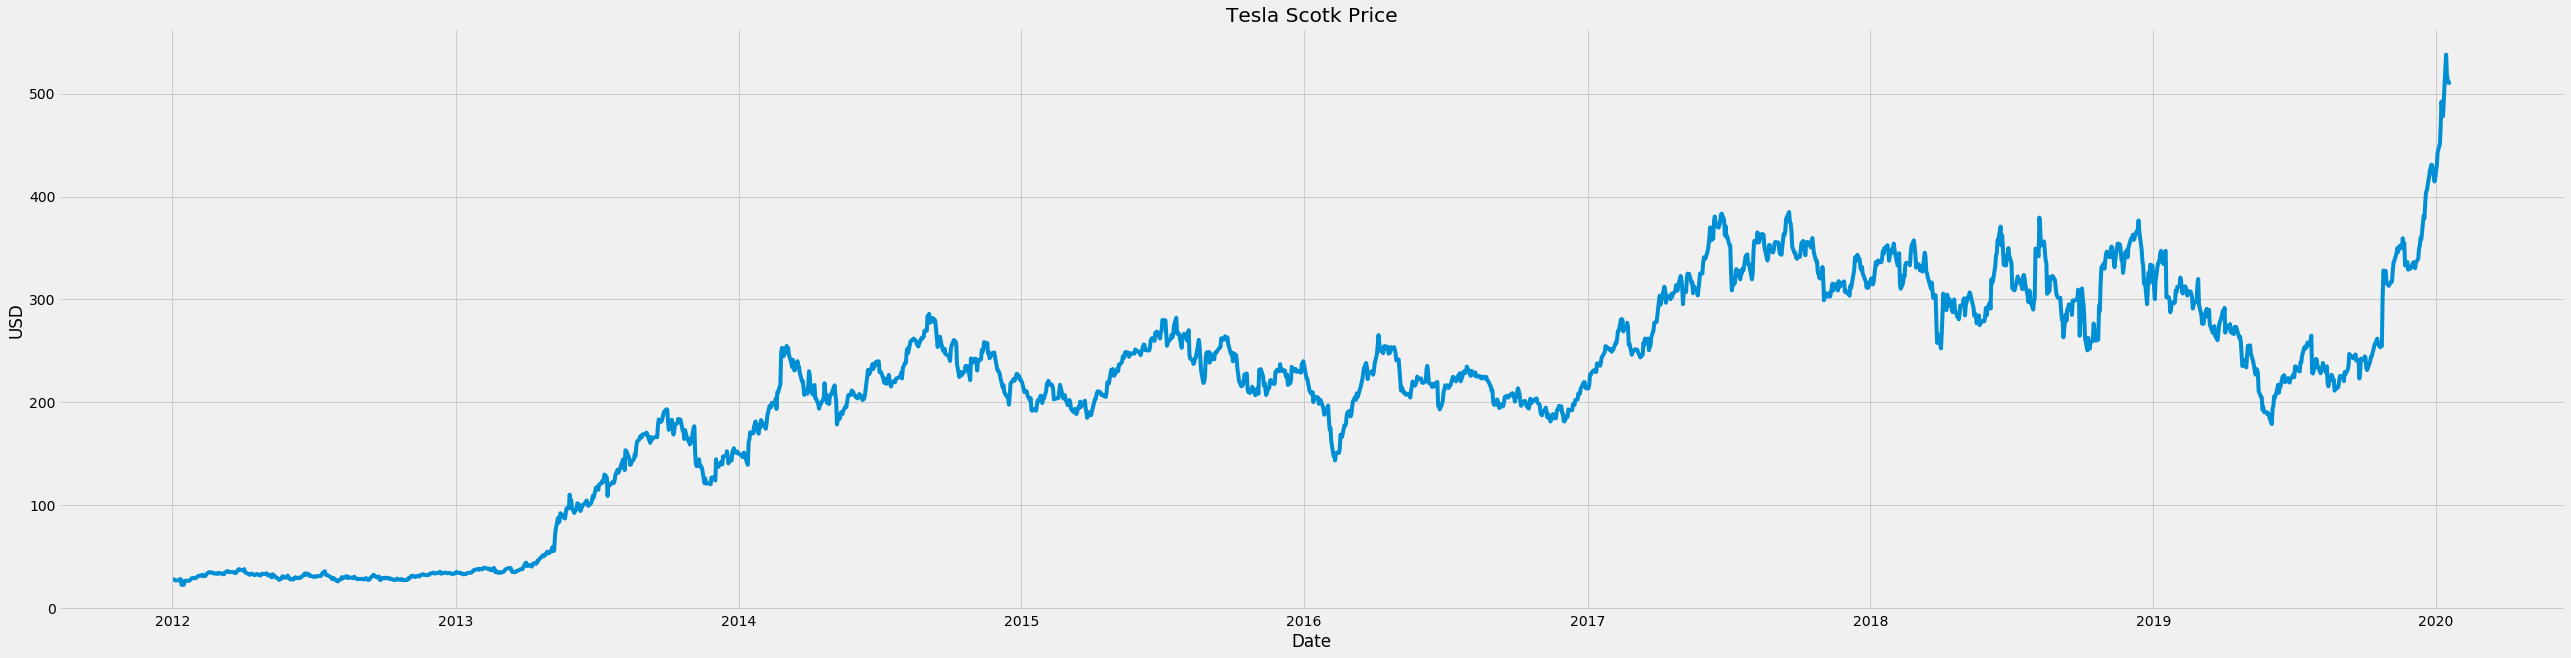

In [302]:
rcParams['figure.figsize'] = 40, 10
plot_df(tesla, tesla.index , tesla['Close'], title='Tesla Scotk Price',ylabel='USD')

Now let's try to extract the subcomponents. 

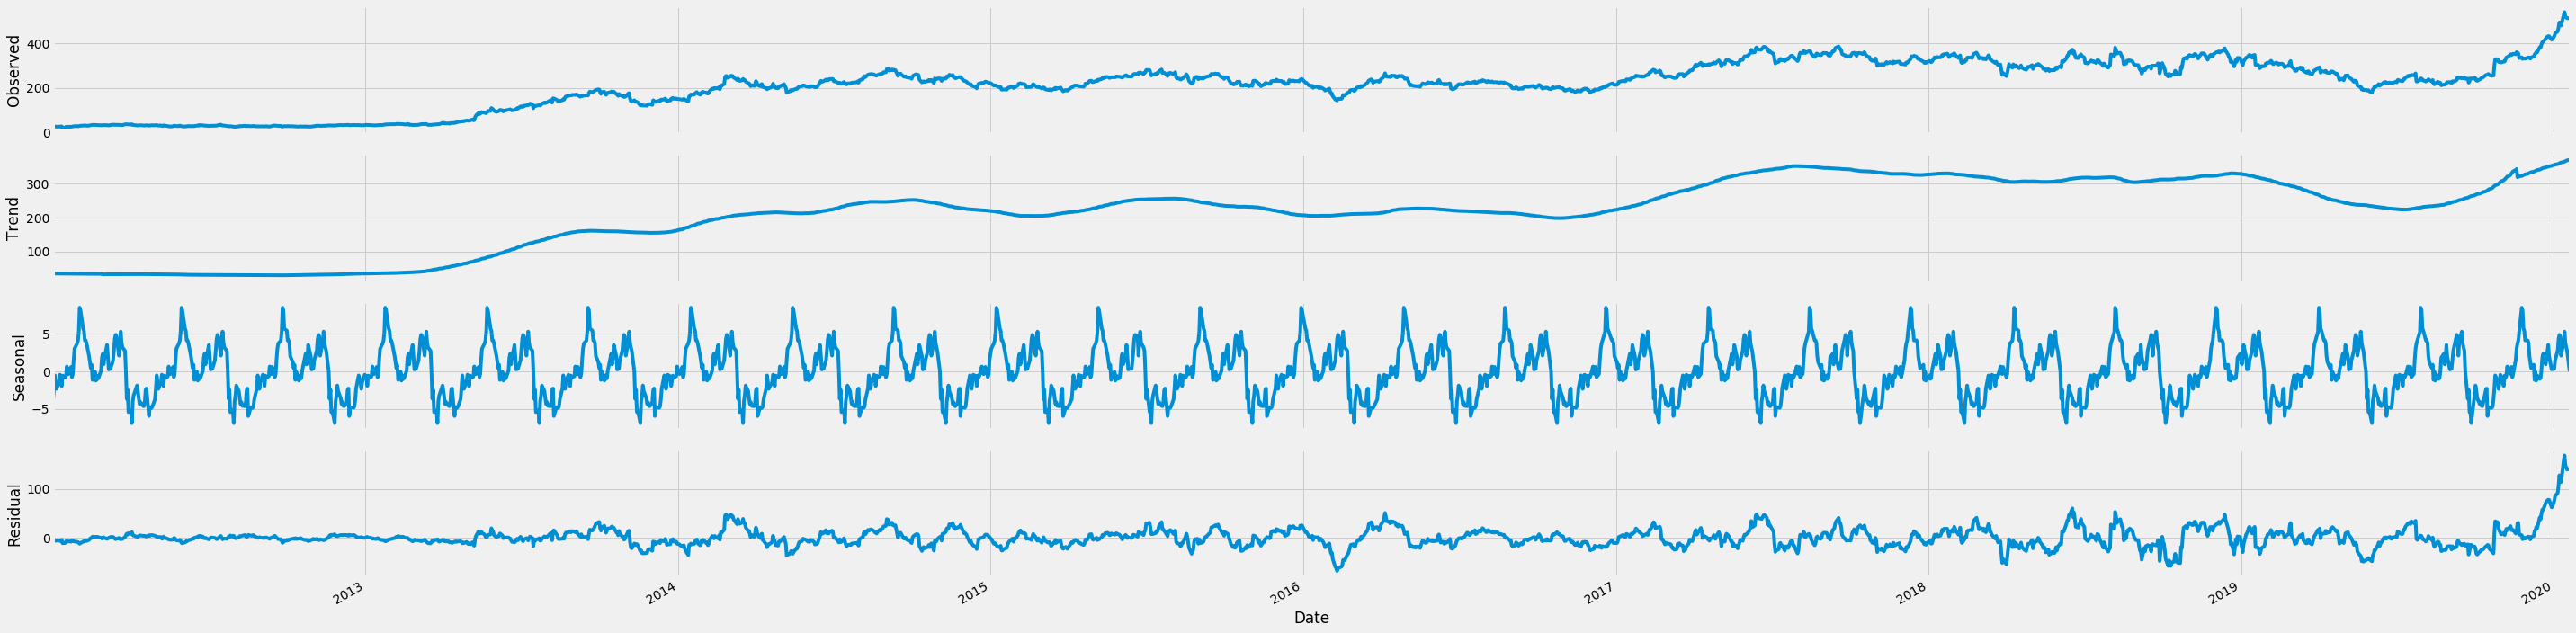

In [303]:
decomposition = sm.tsa.seasonal_decompose(tesla['Close'], model='additive', freq=7*4*3,extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

On the example above, we are using `freq= 7*4*3` (~3 months) to model our data. You can tune it by holding into `trend` visualizations. If the trends visualizations is smooth, and the seasonal has patterns, then it's good to continue. 

The `extrapolate_trend='freq'` will make the length of residual, trend, and seasonal the same by taking care of any missing values at the beginning of the series. 

Now that we already decompose the data, let's try to reconstruct and see whether the formula are correct or not. 

In [304]:
tesla_rc = pd.concat([decomposition.seasonal, decomposition.resid, decomposition.trend, decomposition.observed], axis=1)
tesla_rc.columns = ['seasonal', 'residual', 'trend', 'observation']
tesla_rc['total'] = tesla_rc['seasonal'] + tesla_rc['residual'] + tesla_rc['trend']
tesla_rc.head()

,seasonal,residual,trend,observation,total
Date,,,,,
2012-01-02,-3.738150,-2.712656,34.530806,28.080000,28.080000
2012-01-03,-2.291262,-4.131422,34.502684,28.080000,28.080000
2012-01-04,-0.558103,-6.206460,34.474562,27.709999,27.709999
2012-01-05,-1.368688,-5.957750,34.446440,27.120001,27.120001
2012-01-06,-2.347916,-5.160402,34.418318,26.910000,26.910000


In [305]:
(tesla_rc['total'] == tesla_rc['observation']).mean()

1.0

Since the mean of all boolean value is 1, we have a proof that the formula is true. 

# Stationary

Stationary time-series is time series data that the values don't follow a function of time. 

The difference between stationary time-series and non stationary can be obvious in these example ([source](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322))
![](res/stationary.png)



By the example above, we can conclude that variance in stationary time-series will likely to be constant for each window. Why we need stationary time-series? it's because stationary time-series is easier to be analyzed and most of forecasting algorithm works well with stationary time-series.

By looking into our data, it seems that the data is not stationary. If you're a bit skeptical about it, there exists several measurement to test data stationarity: 
- Augmented Dicky Fuller (ADF) test
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

Let's try to check the stationarity of our data using ADF, the most common way to test stationarity. 

In [306]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(tesla['Close'])
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : -0.7349303346862384
P Value : 0.837493178725177



When you run the ADF test, the result should be negative value, and the P-value should beneath certain threshold. For example, we will use p-value < 5%. Based on the result, the ADF Value is -0.7 wich means our data is not stationary enough. This result also show that p-value >5%, even far more than 10%. This indicate that our data is statistically not stationary. 

## Change into stationary time-series

There are some ways to make a series into stationary: 
- Differencing the Series
- Transform the series to its log 
- Transform the series to its root 
- Other combination

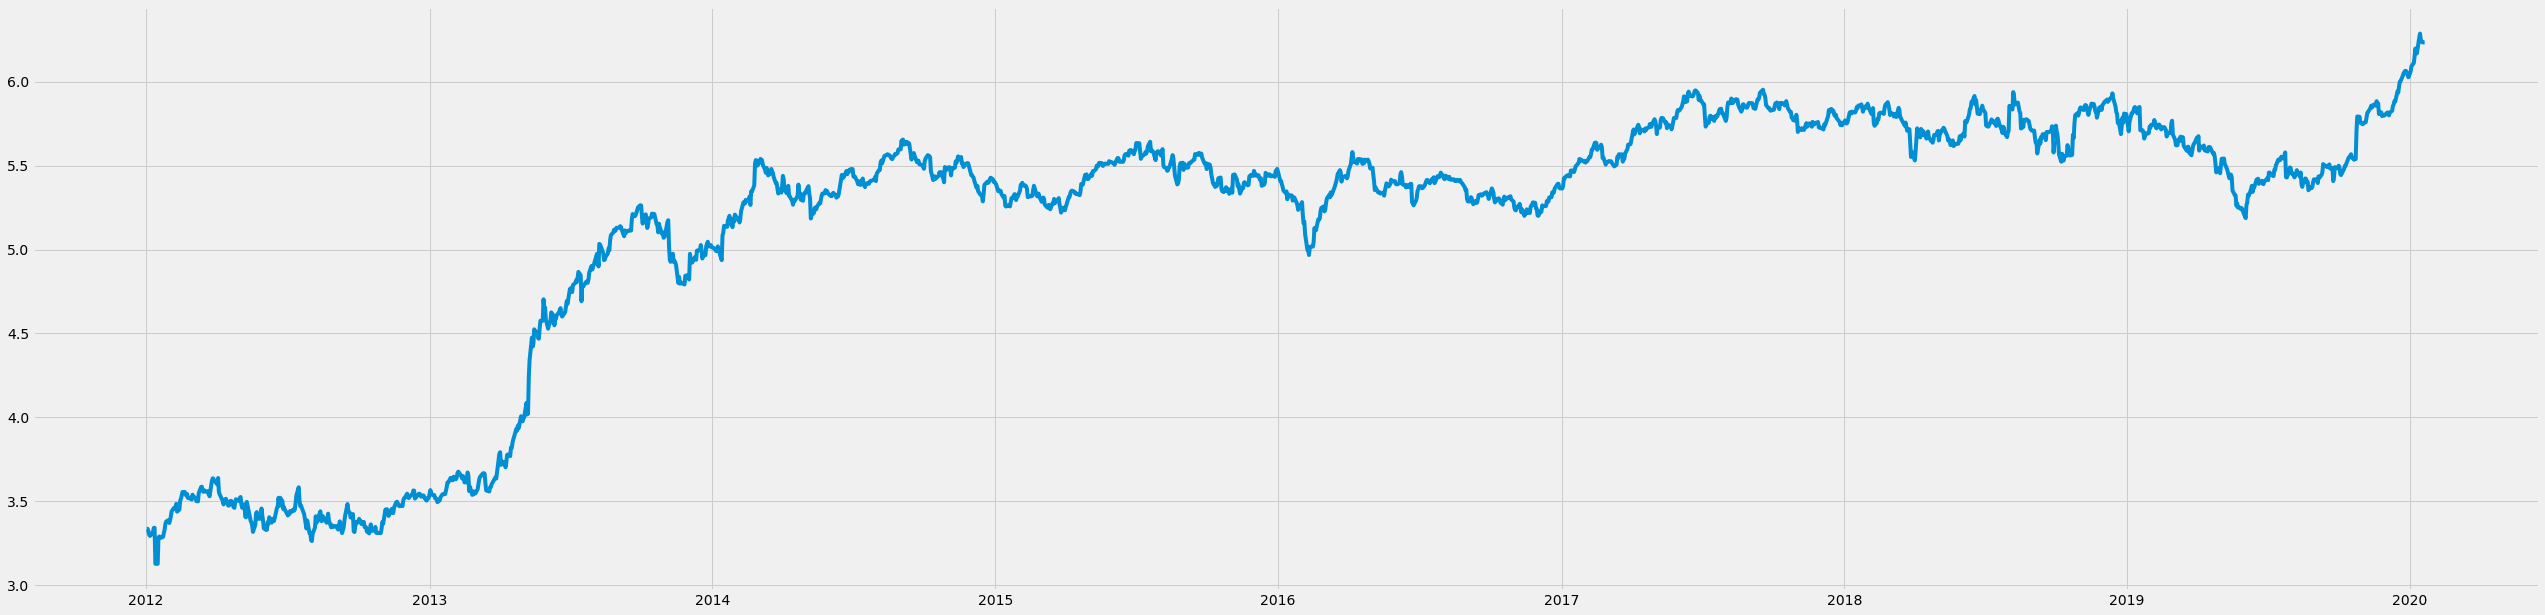

In [353]:
plt.plot(tesla.apply(np.log)['Close'])

In [357]:

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(np.log(tesla['Close']).diff(1).fillna(0))
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : -45.61851051812449
P Value : 0.0



since our data is additive, let's try to difference it using `.diff` method.

In [358]:
tesla_st = tesla.apply(np.log).diff(1)
tesla_st.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-01-04,-0.013264,-0.013264,-0.028539,-0.005440,-0.025548,-0.387261
2012-01-05,-0.021522,-0.021522,-0.026150,-0.023920,-0.016080,0.467362
2012-01-06,-0.007774,-0.007774,-0.005025,-0.016523,-0.020379,-0.019280


If we see, the first data values will be missing since there are no data beforehead. Let's assume that it's the first data, so the difference between the previous one is zero using fillna(0))

In [327]:
tesla_st = tesla_st.fillna(0)
tesla_st.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2012-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-01-04,-0.013264,-0.013264,-0.028539,-0.005440,-0.025548,-0.387261
2012-01-05,-0.021522,-0.021522,-0.026150,-0.023920,-0.016080,0.467362
2012-01-06,-0.007774,-0.007774,-0.005025,-0.016523,-0.020379,-0.019280


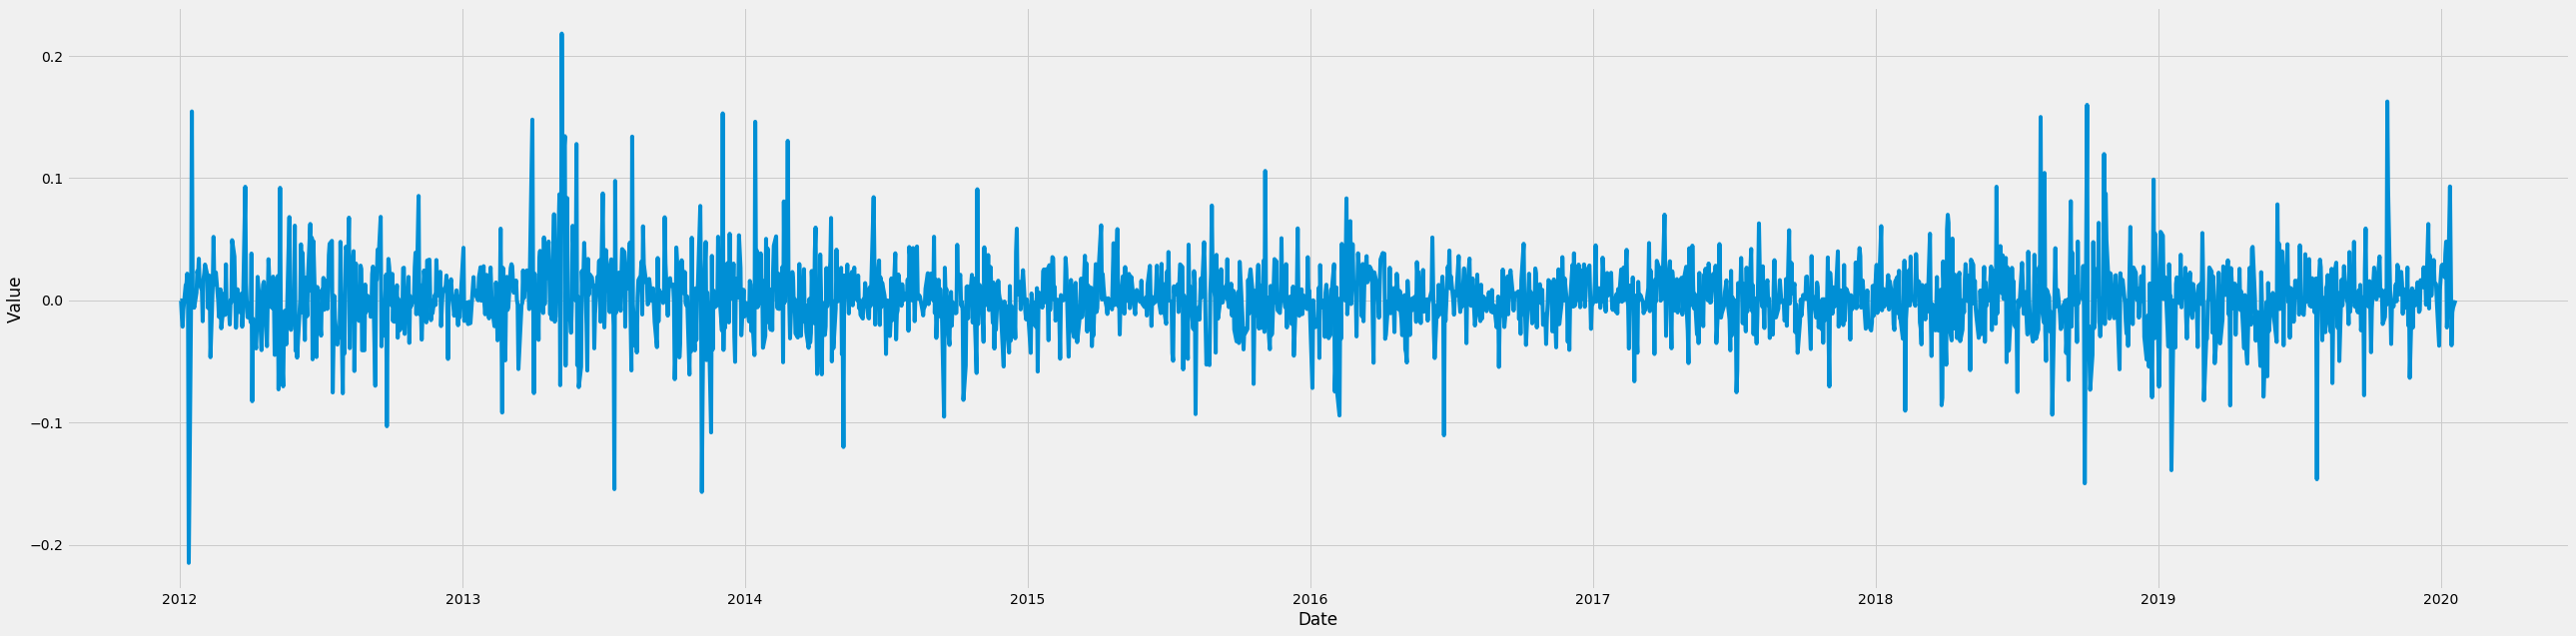

In [328]:
plot_df(tesla_st, tesla_st.index, tesla_st['Close'])

In [354]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(tesla['Close'].apply(np.log))
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : -1.845695912607128
P Value : 0.35802234148912654



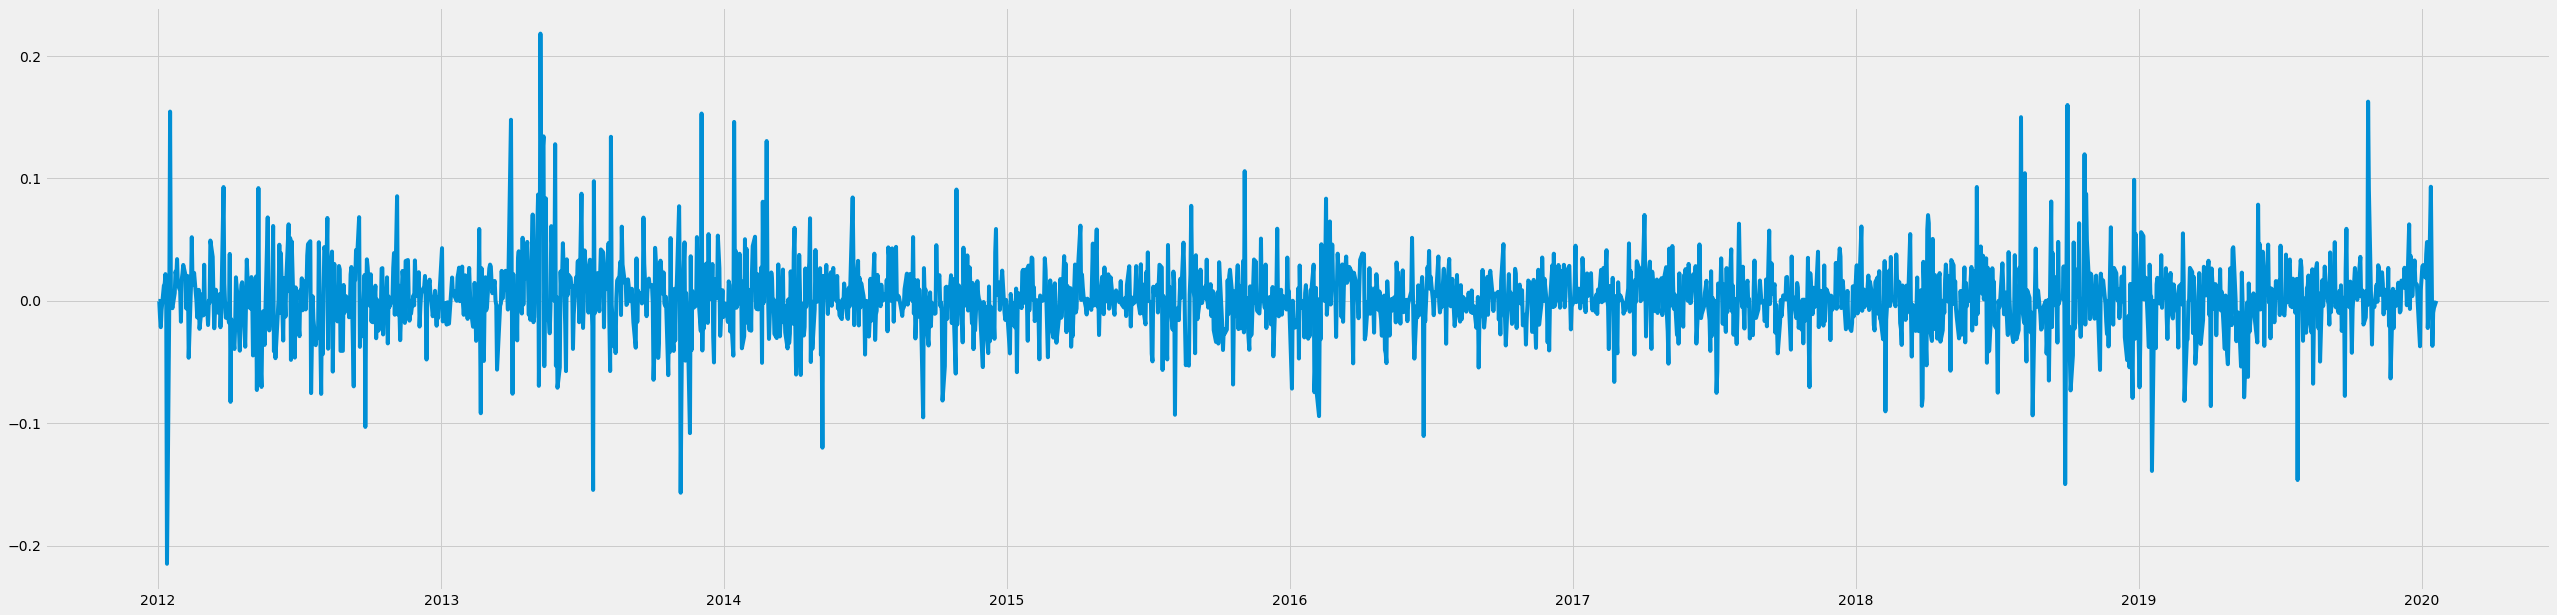

In [355]:
plt.plot(np.log(tesla['Close']).diff().fillna(0))

Based on the chart, our transformed data seems more stationary. If you're a bit skeptical about the result, there exists several measurement to test data stationarity: 
- Augmented Dicky Fuller (ADF) test
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

Let's try using ADF, the most common way to test stationarity. 

In [329]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(tesla_st['Close'])
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")



ADF Value : -45.61851051812449
P Value : 0.0



When you run the ADF test, the result should be negative value, and the P-value should beneath certain threshold. For example, we will use p-value < 5%. Based on the result, the ADF Value is -7 wich means our data is stationary enough. with confidental value (p-value) < 5%, it means that our data is statistically stationary. 

But, doing transformation means we changed the data. Yes, **we changed the data**. But don't worry, we can still try to reconstruct it into original form. However, it depends on how you changed the data. Since we are using diff wich resuling in the differences between current data and previous one, a cumulative sum (`cumsum`) will work as a cure. 

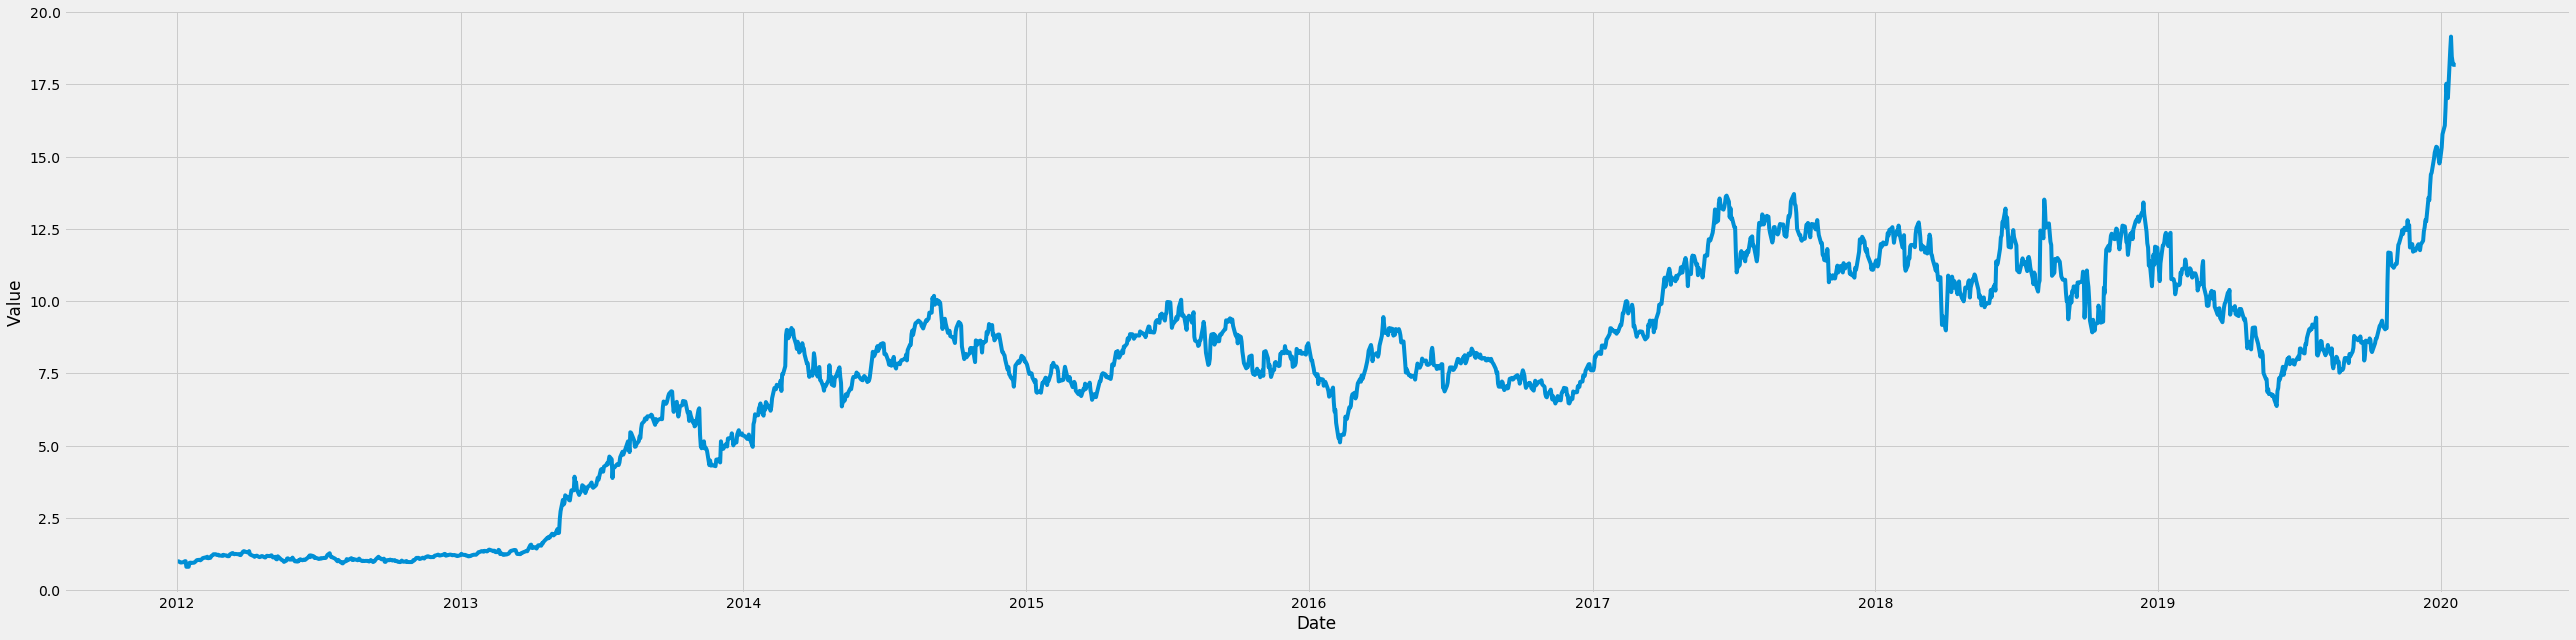

In [330]:
tesla_reconstruct = tesla_st.copy()
tesla_reconstruct = tesla_reconstruct.cumsum().apply(np.exp)
plot_df(tesla_reconstruct, tesla_reconstruct.index, tesla_reconstruct.cumsum().apply(np.exp)['Close'])

However, doing a cumulative sum doesn't re-transfrom the data into its original value. This is caused by the first value of the data is zero (previously nan, changed to zero). We need the initial data so that it can transform into it's original values. 

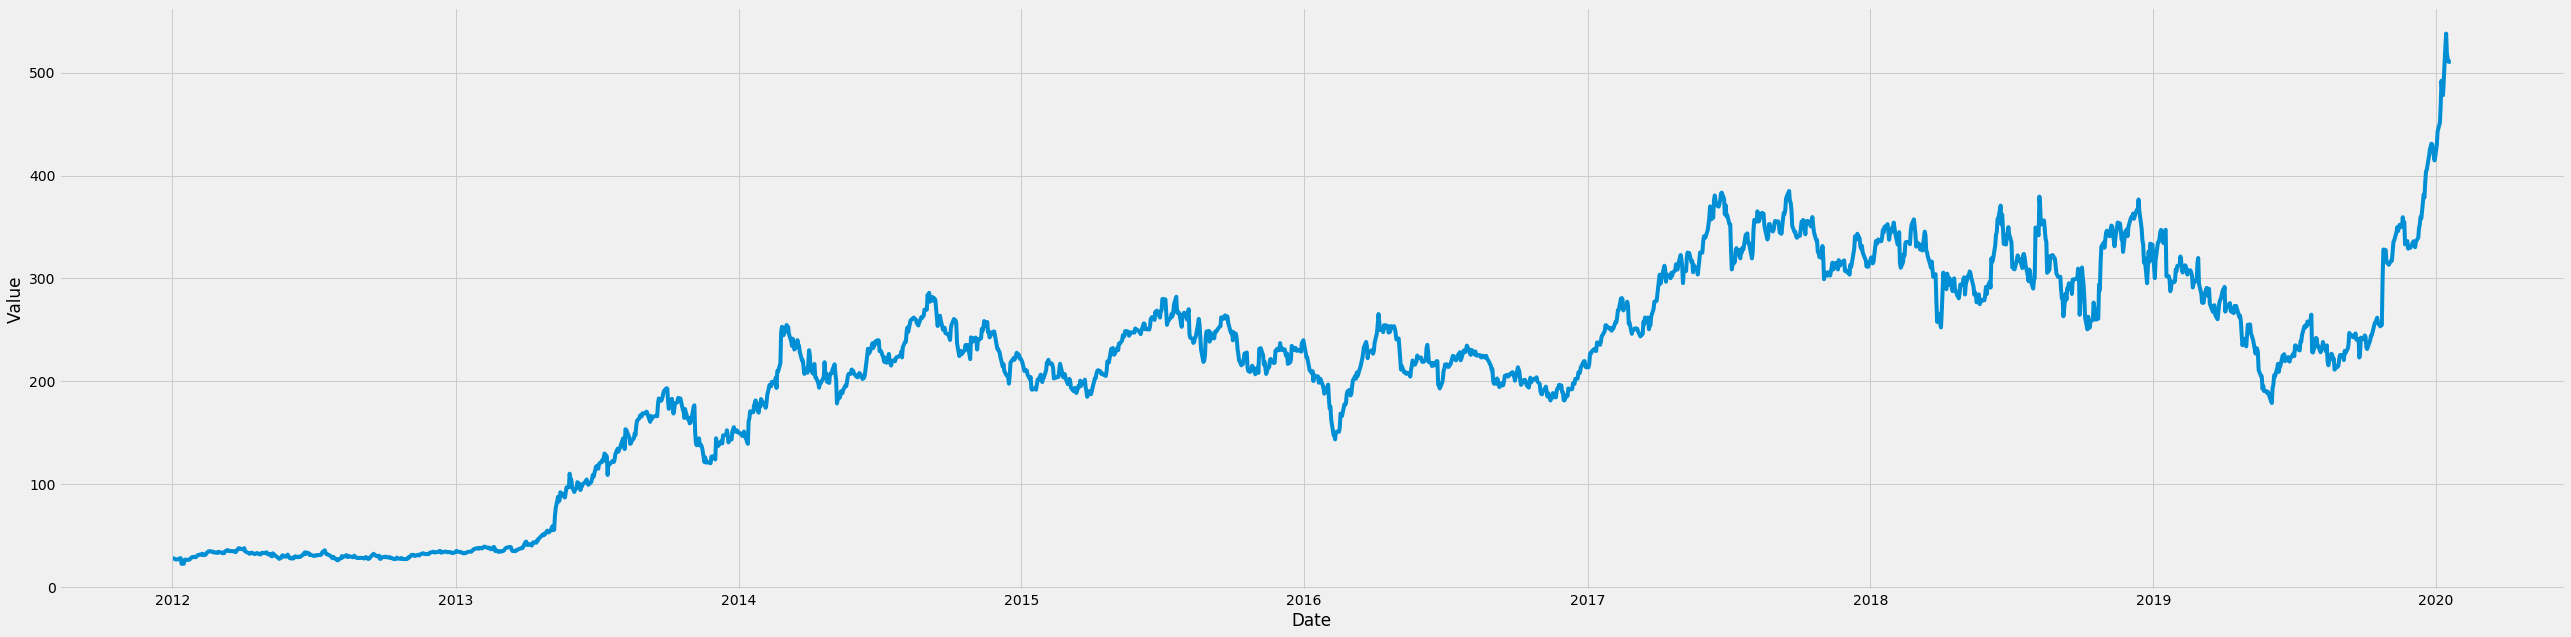

In [331]:
# return the first value of the data to be original value 
tesla_st.iloc[0,:] = tesla.iloc[0,:].apply(np.log)
tesla_st_returned = tesla_st.cumsum().apply(np.exp)
plot_df(tesla_st, tesla_st.index, tesla_st_returned['Close'])

# Autocorrelation and Partial Autocorrelation

Autocorrelation is.. 

partial autocorrelation is.. 

rumus rumus

In [107]:
tesla['Close'].fillna(method='bfill').fillna(method = 'ffill')

Date
2012-01-02     28.080000
2012-01-03     28.080000
2012-01-04     27.709999
2012-01-05     27.120001
2012-01-06     26.910000
                 ...    
2020-01-14    537.919983
2020-01-15    518.500000
2020-01-16    513.489990
2020-01-17    510.500000
2020-01-20    510.500000
Name: Close, Length: 2078, dtype: float64

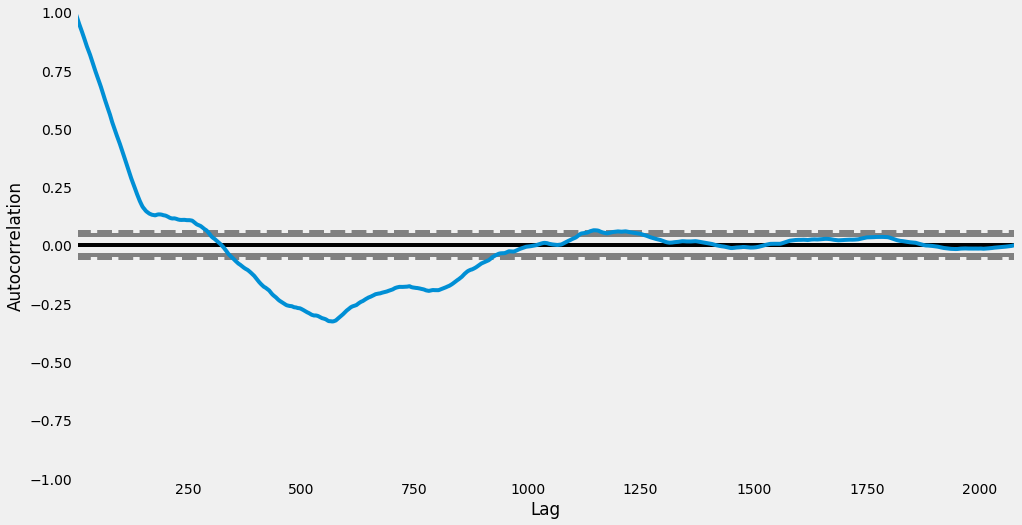

In [114]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15, 8))
autocorrelation_plot(vw['Close'].fillna(method='bfill').fillna(method = 'ffill'))

# Time Series Forecasting (ARIMA)

In [184]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults, ARIMAResultsWrapper

## Modelling

In [371]:
model_arima = ARIMA(tesla_st['Close'].values, order=(3,1,3))

In [372]:
result_arima = model_arima.fit(disp=-1)

MissingDataError: exog contains inf or nans

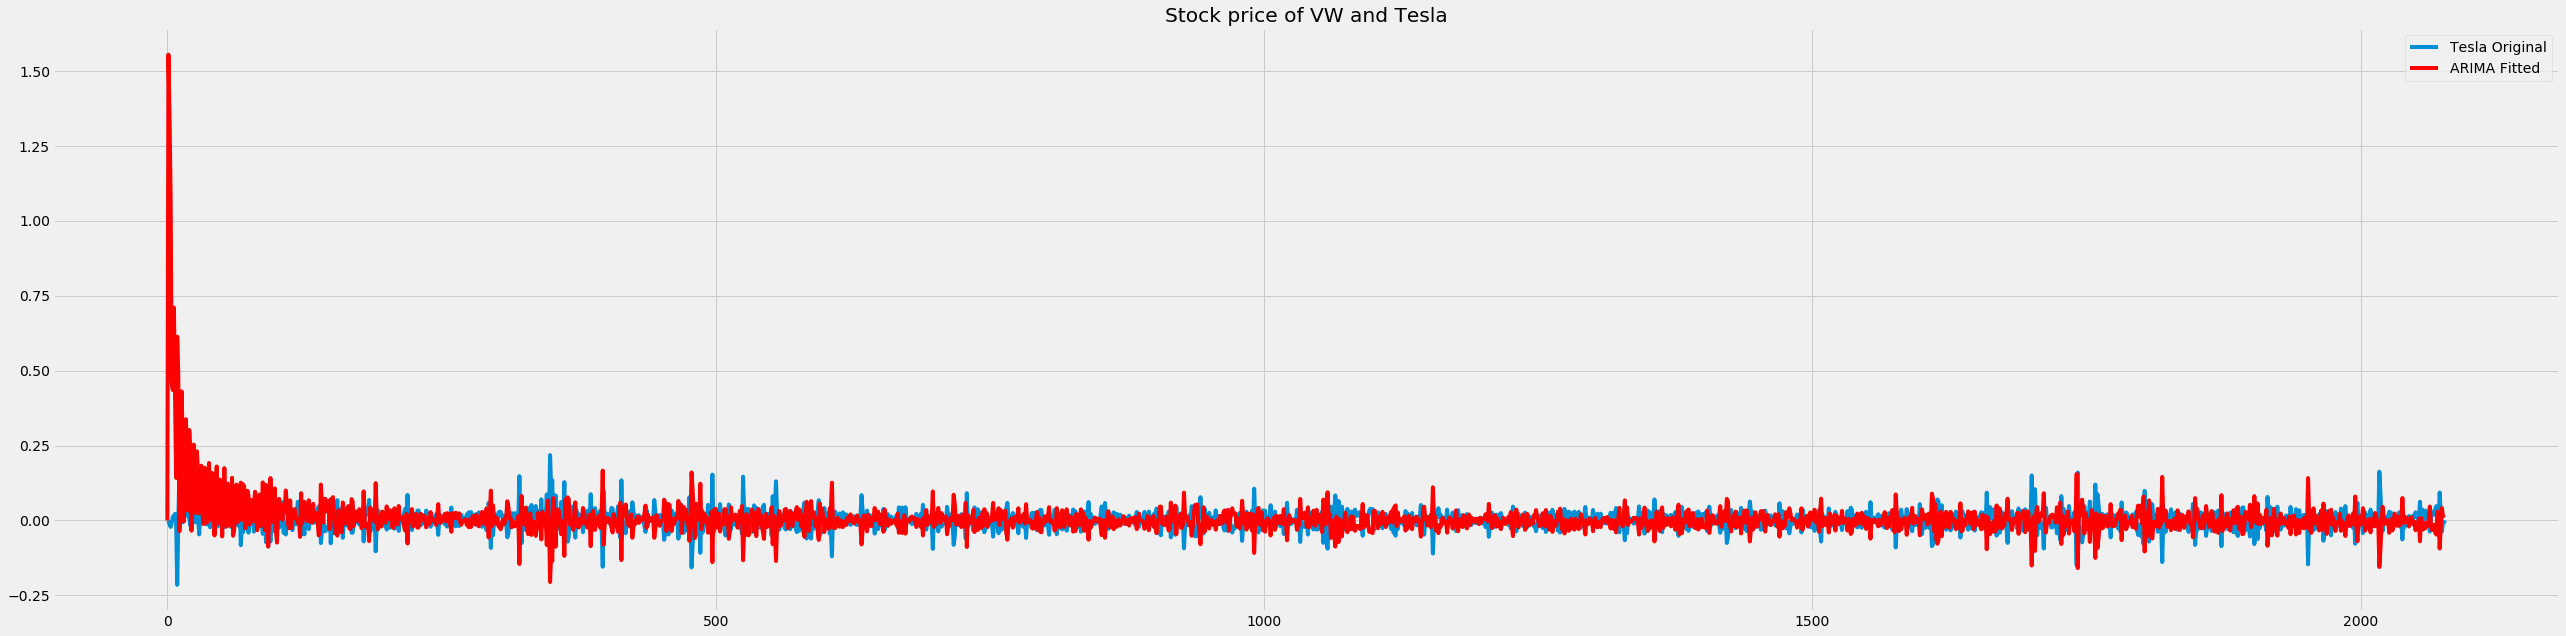

In [359]:
plt.plot(tesla_st['Close'].values, label='Tesla Original')
plt.plot(result_arima.fittedvalues, color='red', label='ARIMA Fitted')

# plt.plot(vw.index, vw['Close'], 'b-', label = 'VW')
# plt.plot(tesla.index, tesla['Close'], 'r-', label = 'TESLA')
# plt.xlabel('Date'); plt.ylabel('Stock Price (USD)')
plt.title('Stock price of VW and Tesla')
plt.legend();

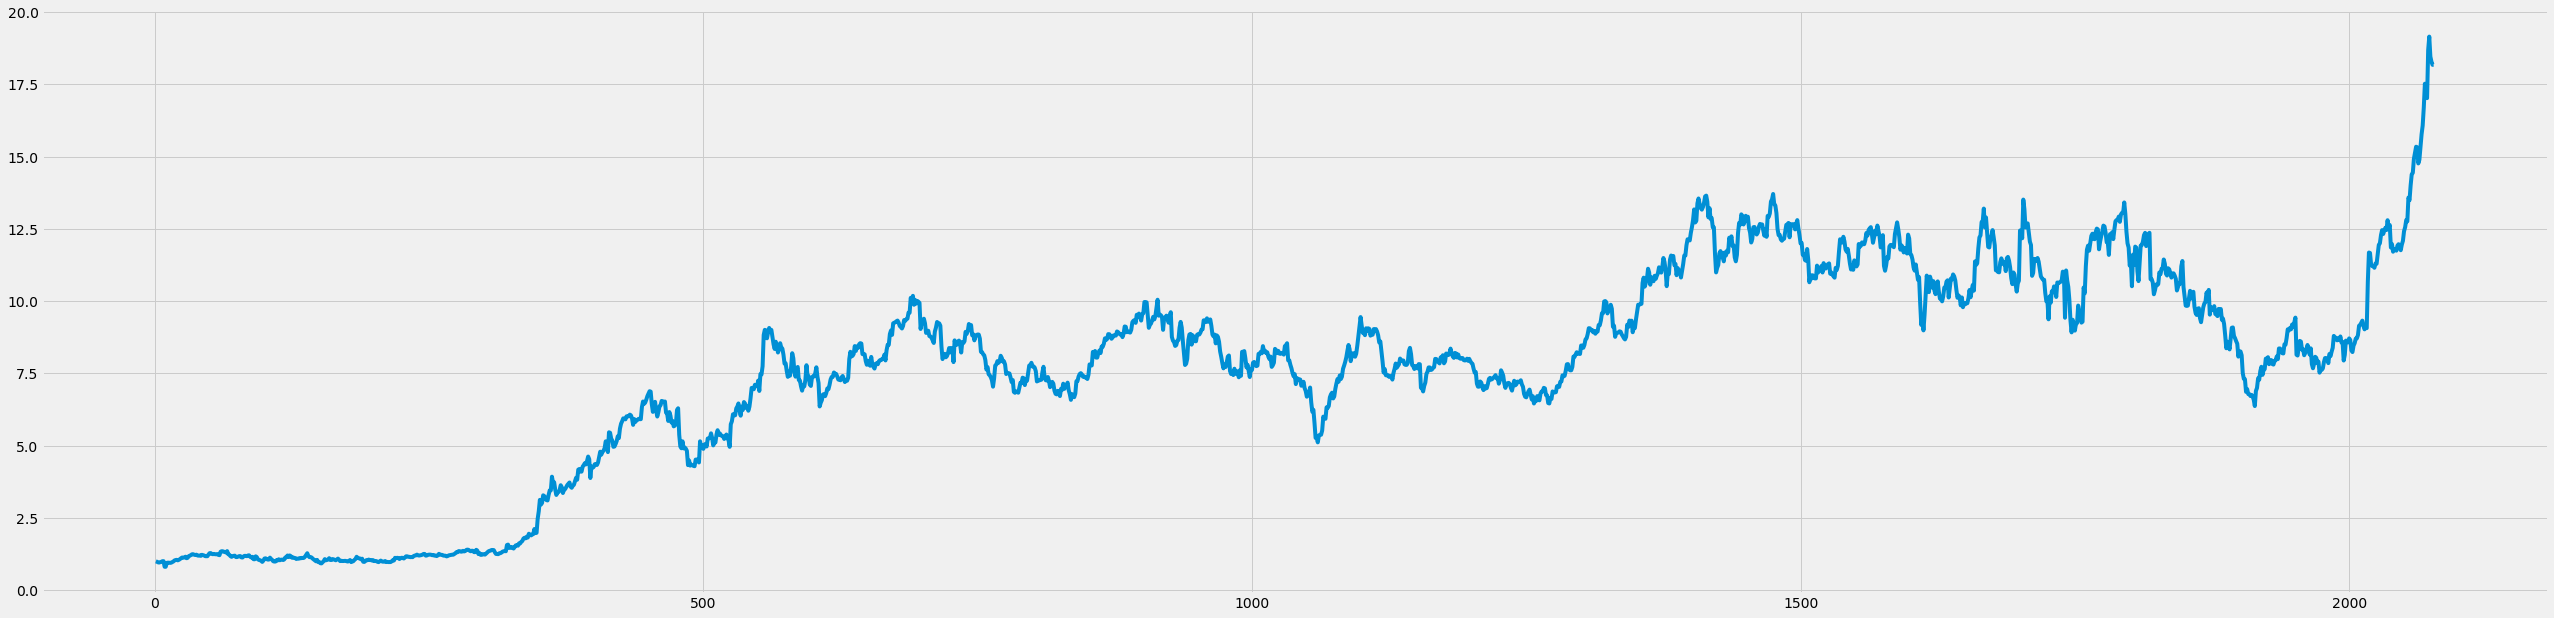

In [366]:
# plt.plot(np.exp(tesla_st['Close'].cumsum()).values)
plt.plot(np.exp(result_arima.fittedvalues.cumsum()), color='red')

# plt.title('Stock price of VW and Tesla')
# plt.legend();

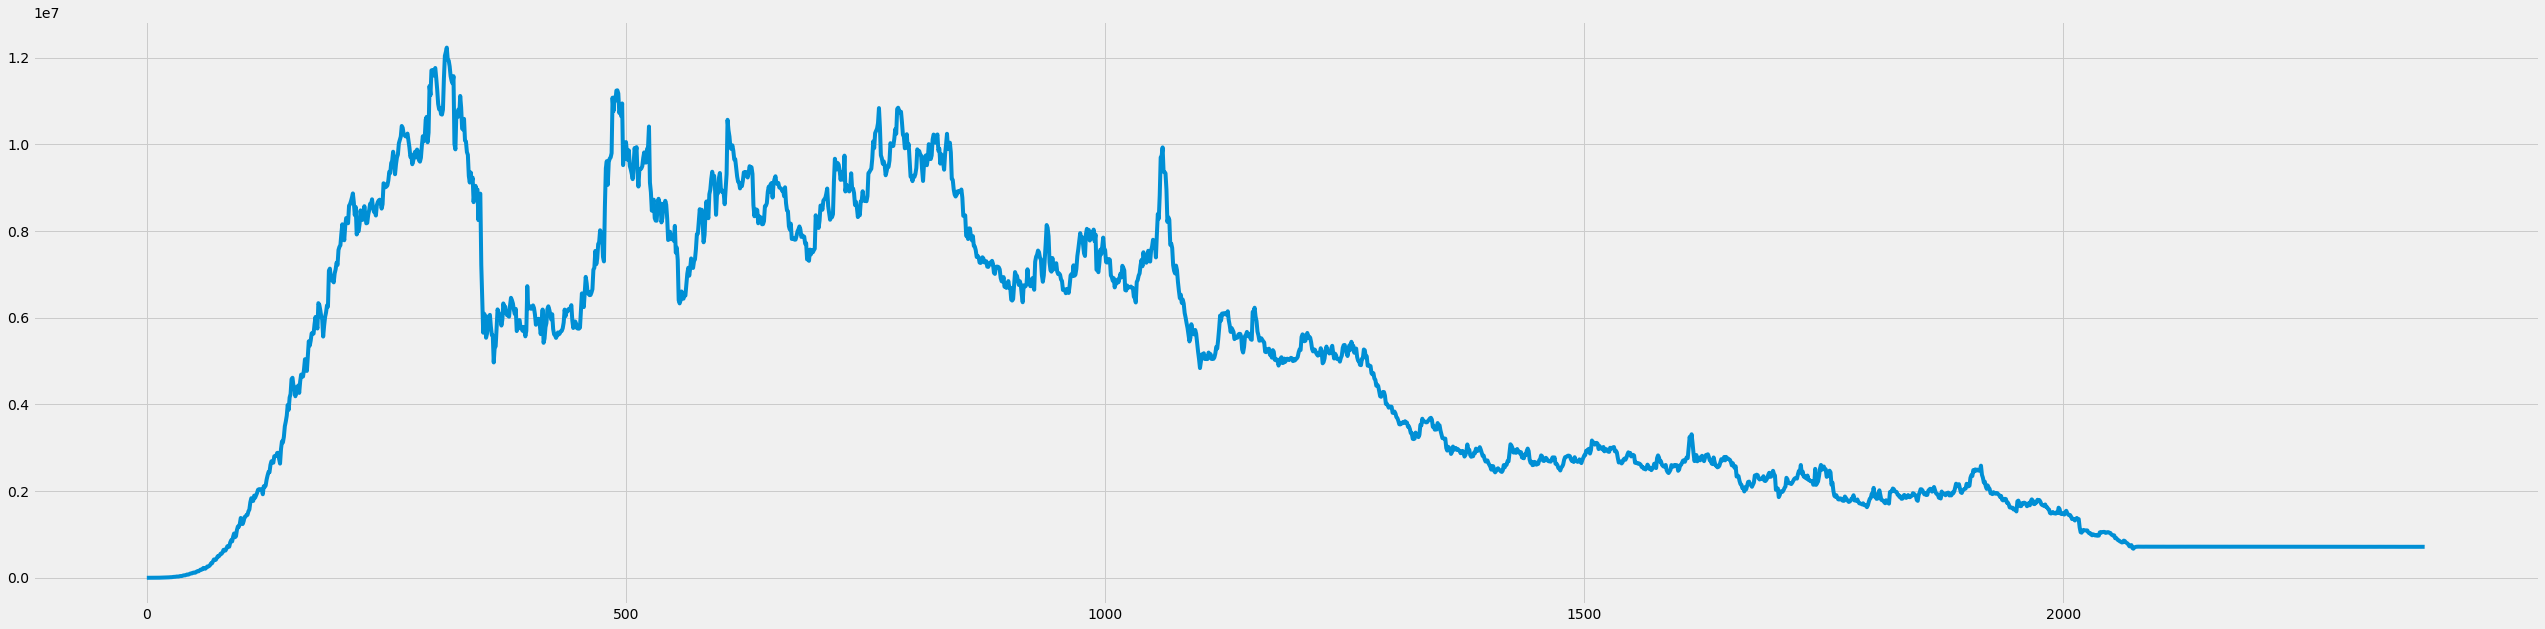

In [339]:
plt.plot(np.exp(result_arima.predict(1, len(tesla_st)+300).cumsum()))

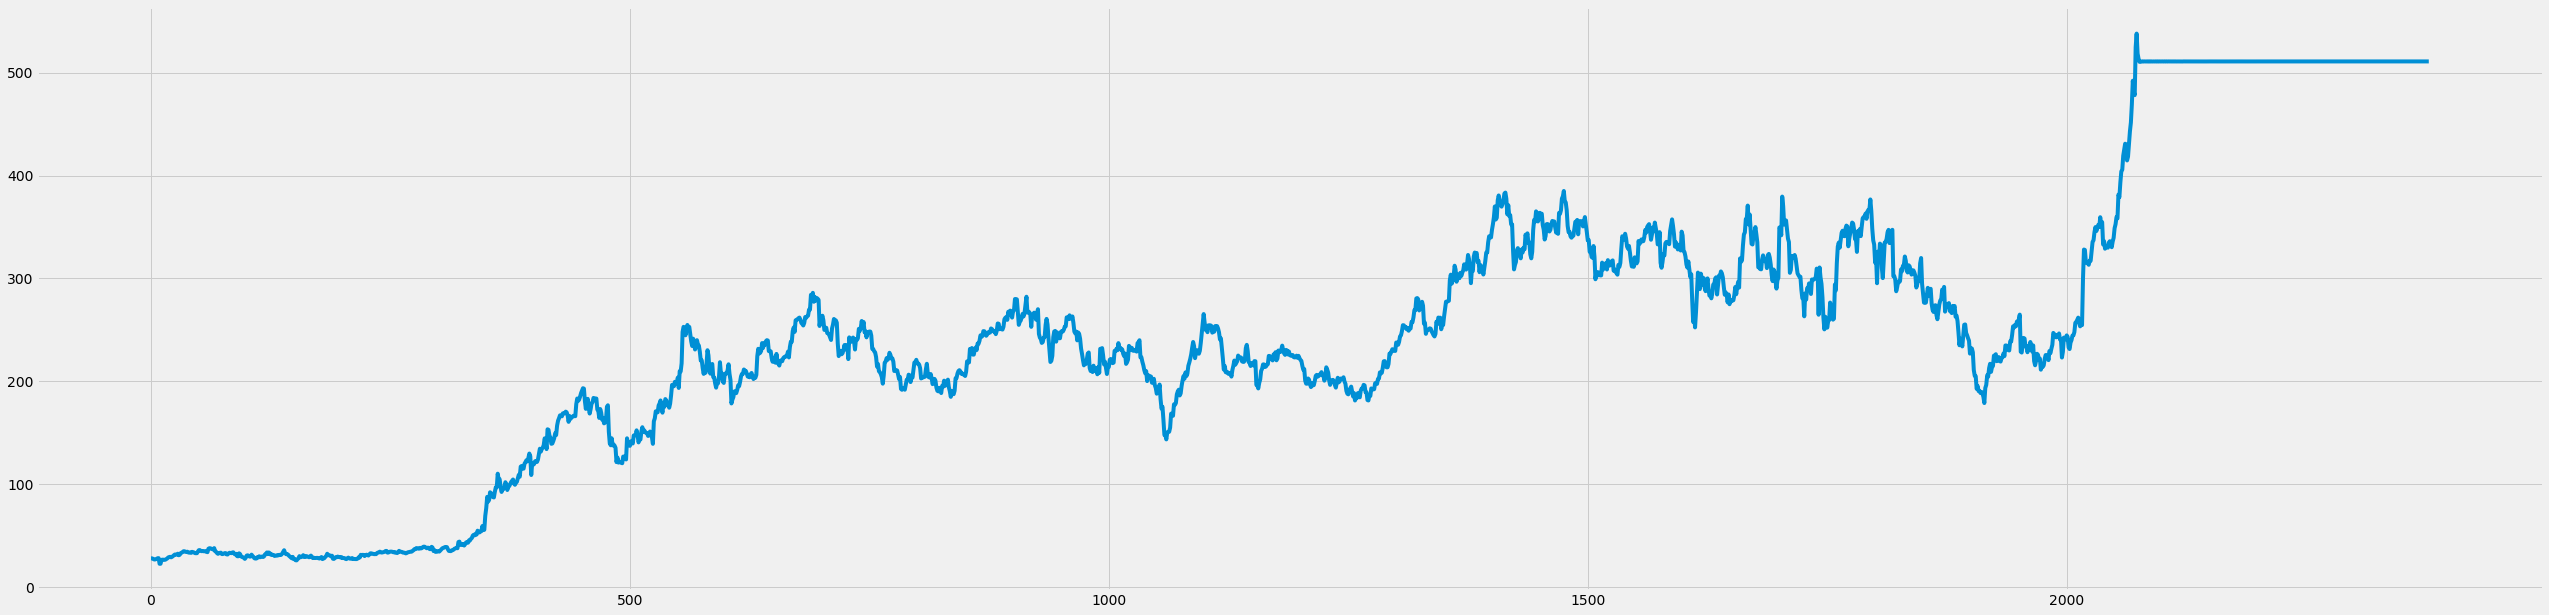

In [271]:
plt.plot(np.append(
    tesla['Close'][:-1],
    (np.append( tesla['Close'][-1], result_arima.predict(len(tesla_st), len(tesla_st)+300)).cumsum())
))

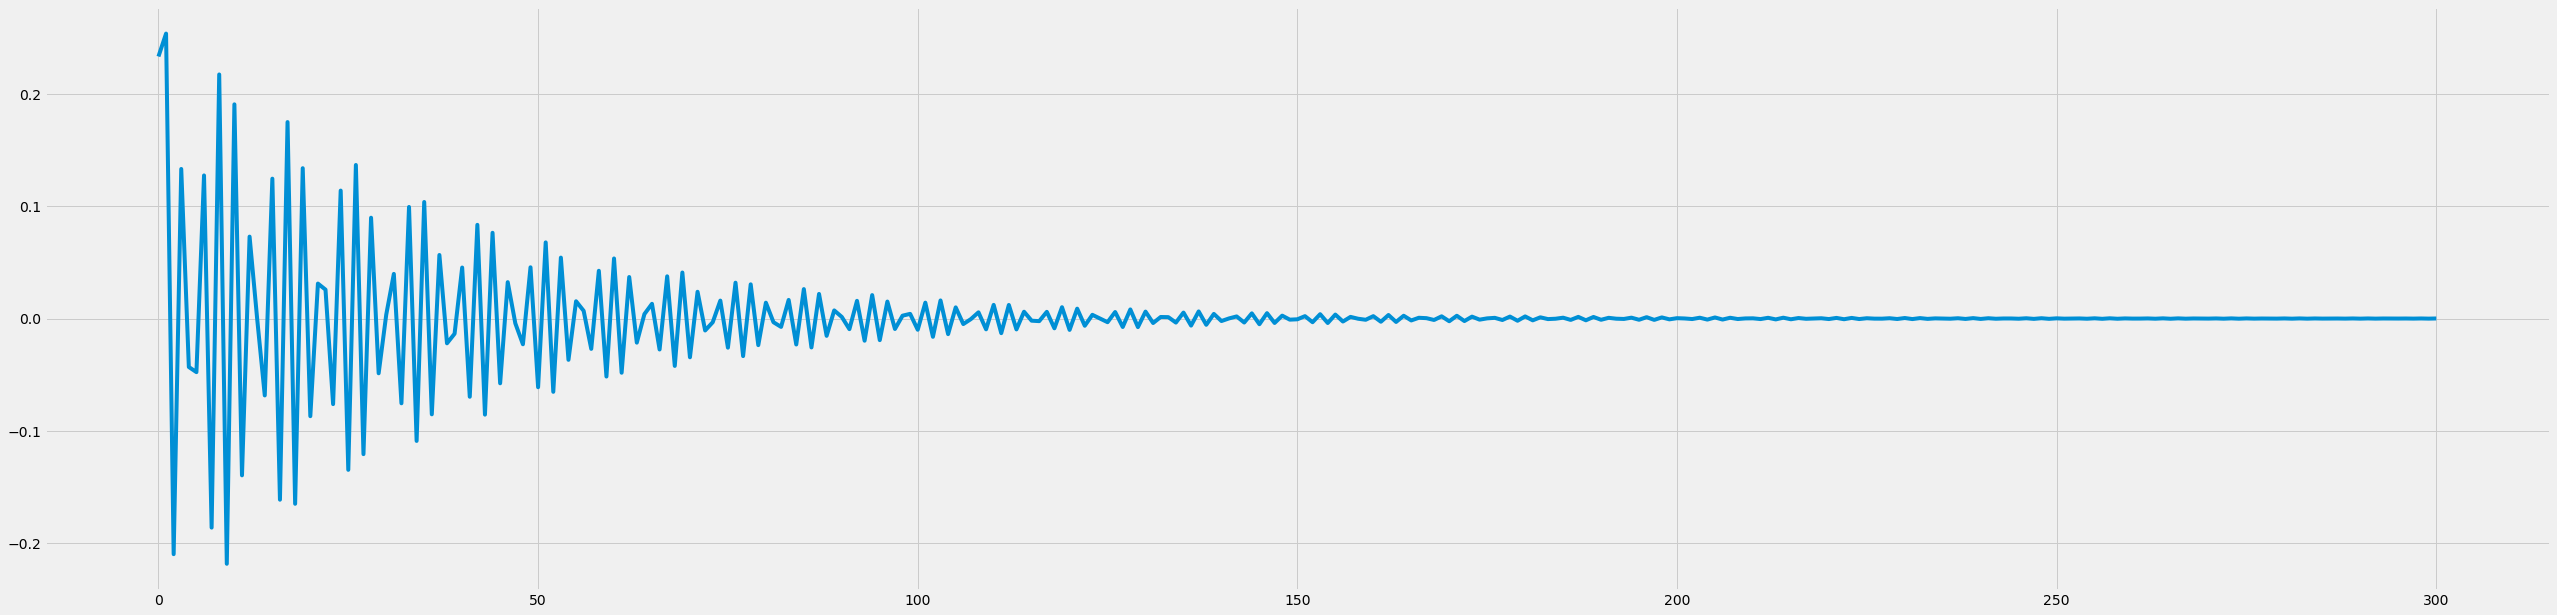

In [289]:
plt.plot(result_arima.predict(len(tesla_st), len(tesla_st)+300))

## Model Evaluation

In [ ]:
log